***Human Embryo Images Segmentation***
#
This Jupyter notebook is responsible for **loading**, **preprocessing**, and **augmenting** a small dataset of human embryo images and their corresponding segmentation masks (**ZP**, **TE**, and **ICM**). These masks are essential for training models to identify different embryo structures — a critical task in the IVF process.

*Mask Categories*

- **ZP**: *Zona Pellucida*
- **TE**: *Trophectoderm*
- **ICM**: *Inner Cell Mass*


In [ ]:
import albumentations as A
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

***Dataset Loading***

- Reads **grayscale embryo images** and corresponding **ground truth masks** from directories.
- Applies **resizing (256×256)** to standardize input dimensions for deep learning models.

In [ ]:
icm_zp_dir = '/content/drive/MyDrive/pfa-dataset1/GT_ICM'
te_zp_dir = '/content/drive/MyDrive/pfa-dataset1/GT_TE'
gt_zp_dir = '/content/drive/MyDrive/pfa-dataset1/GT_ZP'
image_dir = '/content/drive/MyDrive/pfa-dataset1/Images'

# read the images and masks
images = []
zp_masks = []
te_masks = []
icm_masks = []
SIZE = 256

file_names = os.listdir(image_dir)

for file_name in file_names:
    image_path = os.path.join(image_dir, file_name)
    zp_mask_path = os.path.join(gt_zp_dir, file_name.replace('.BMP', ' ZP_Mask.bmp'))
    te_mask_path = os.path.join(te_zp_dir, file_name.replace('.BMP', ' TE_Mask.bmp'))
    icm_mask_path = os.path.join(icm_zp_dir, file_name.replace('.BMP', ' ICM_Mask.bmp'))

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    zp_mask = cv2.imread(zp_mask_path, cv2.IMREAD_GRAYSCALE)
    te_mask = cv2.imread(te_mask_path, cv2.IMREAD_GRAYSCALE)
    icm_mask = cv2.imread(icm_mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (SIZE, SIZE))
    zp_mask = cv2.resize(zp_mask, (SIZE, SIZE))
    te_mask = cv2.resize(te_mask, (SIZE, SIZE))
    icm_mask = cv2.resize(icm_mask, (SIZE, SIZE))

    images.append(image)
    zp_masks.append(zp_mask)
    te_masks.append(te_mask)
    icm_masks.append(icm_mask)

images = np.array(images)
zp_masks = np.array(zp_masks)
te_masks = np.array(te_masks)
icm_masks = np.array(icm_masks)

print(images.shape)
print(zp_masks.shape)
print(te_masks.shape)
print(icm_masks.shape)

(249, 256, 256)
(249, 256, 256)
(249, 256, 256)
(249, 256, 256)


***Visualization***

- Displays one sample image alongside its three associated masks for **qualitative inspection**.

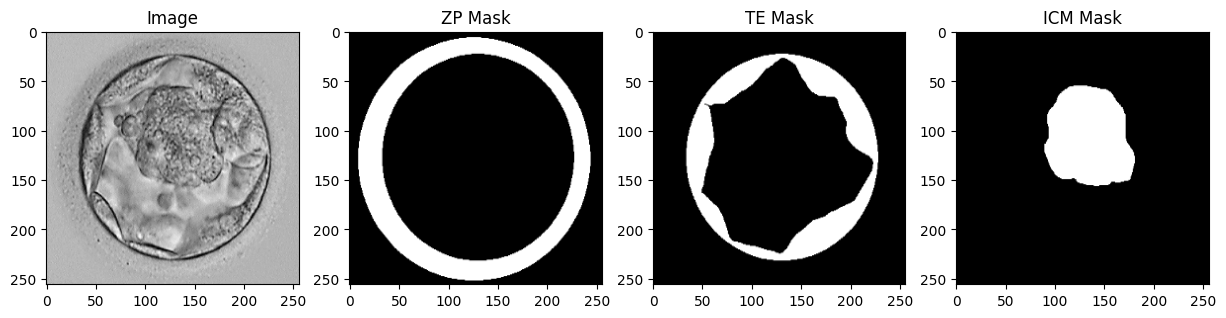

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(images[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 4, 2)
plt.imshow(zp_masks[0], cmap='gray')
plt.title('ZP Mask')

plt.subplot(1, 4, 3)
plt.imshow(te_masks[0], cmap='gray')
plt.title('TE Mask')

plt.subplot(1, 4, 4)
plt.imshow(icm_masks[0], cmap='gray')
plt.title('ICM Mask')

plt.show()

***Data Augmentation (Albumentations)***

- Uses advanced **geometric** and **photometric** transformations:
  - Horizontal/Vertical flips
  - Rotations
  - Affine transformations
  - Brightness/Contrast adjustments
- Augments each image-mask group **3 times** to:
  - Enrich the dataset
  - Mitigate overfitting (especially important given the small size of the medical dataset)
- Saves the **augmented images and masks** to new directories for training.

In [ ]:
'''
def plot_augmented_image_and_mask(image, zp_mask, te_mask, icm_mask):
    fig, axs = plt.subplots(1, 4, figsize=(8, 4))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Augmented Image')
    axs[1].imshow(zp_mask, cmap='gray')
    axs[1].set_title('ZP Mask')
    axs[2].imshow(te_mask, cmap='gray')
    axs[2].set_title('TE Mask')
    axs[3].imshow(icm_mask, cmap='gray')
    axs[3].set_title('ICM Mask')
    plt.show()
'''

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.Affine(scale=(0.9, 1.1), rotate=(-20, 20), translate_percent=(0.1, 0.2), p=0.5),
    A.RandomBrightnessContrast(p=0.2),  # Only applied to the image, not the mask
])

num_augmented_images = 3
augmented_icm_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ICM'
augmented_zp_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ZP'
augmented_te_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_TE'
augmented_images_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/Images'

for idx, (image, zp_mask, te_mask, icm_mask) in enumerate(zip(images, zp_masks, te_masks, icm_masks)):
  for i in range(num_augmented_images):
      # Apply augmentation
      augmented = augment(image=image, masks=[zp_mask, te_mask, icm_mask])

      augmented_image = augmented['image']
      augmented_zp_mask, augmented_te_mask, augmented_icm_mask = augmented['masks']

      # Save the augmented images and masks with different filenames
      cv2.imwrite(os.path.join(augmented_images_dir, f"{idx}_{i}.png"), augmented_image)
      cv2.imwrite(os.path.join(augmented_zp_dir, f"{idx}_{i} ZP_Mask.png"), augmented_zp_mask)
      cv2.imwrite(os.path.join(augmented_te_dir, f"{idx}_{i} TE_Mask.png"), augmented_te_mask)
      cv2.imwrite(os.path.join(augmented_icm_dir, f"{idx}_{i} ICM_Mask.png"), augmented_icm_mask)